TV-Regularized Low-Dose CT Reconstruction
=========================================

This example demonstrates solution of a low-dose CT reconstruction problem
with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_W^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection),
$\mathbf{y}$ is the sinogram, the norm weighting $W$ is chosen so that
the weighted norm is an approximation to the Poisson negative log
likelihood <cite data-cite="sauer-1993-local"/>, $C$ is a 2D finite difference
operator, and $\mathbf{x}$ is the desired image.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install 'scico[examples] @ git+https://github.com/lanl/scico'

import numpy as np

from xdesign import Soil, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray.astra import XRayTransform2D
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
np.random.seed(0)
x_gt = discrete_phantom(Soil(porosity=0.80), size=384)
x_gt = np.ascontiguousarray(np.pad(x_gt, (64, 64)))
x_gt = np.clip(x_gt, 0, np.inf)  # clip to positive values
x_gt = snp.array(x_gt)  # convert to jax type

Configure CT projection operator and generate synthetic measurements.

In [3]:
n_projection = 360  # number of projections
Io = 1e3  # source flux
𝛼 = 1e-2  # attenuation coefficient
angles = np.linspace(0, 2 * np.pi, n_projection, endpoint=False)  # evenly spaced projection angles
A = XRayTransform2D(x_gt.shape, N, 1.0, angles)  # CT projection operator
y_c = A @ x_gt  # sinogram

Add Poisson noise to projections according to

$$\mathrm{counts} \sim \mathrm{Poi}\left(I_0 exp\left\{- \alpha A
\mathbf{x} \right\}\right)$$

$$\mathbf{y} = - \frac{1}{\alpha} \log\left(\mathrm{counts} /
I_0\right).$$

We use the NumPy random functionality so we can generate using 64-bit
numbers.

In [4]:
counts = np.random.poisson(Io * snp.exp(-𝛼 * A @ x_gt))
counts = np.clip(counts, a_min=1, a_max=np.inf)  # replace any 0s count with 1
y = -1 / 𝛼 * np.log(counts / Io)
y = snp.array(y)  # convert back to float32 as a jax array

Set up post processing. For this example, we clip all reconstructions
to the range of the ground truth.

In [5]:
def postprocess(x):
    return snp.clip(x, 0, snp.max(x_gt))

Compute an FBP reconstruction as an initial guess.

In [6]:
x0 = postprocess(A.fbp(y))

Set up and solve the un-weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;.$$

In [7]:
# Note that rho and lambda were selected via a parameter sweep (not
# shown here).
ρ = 2.5e3  # ADMM penalty parameter
lambda_unweighted = 3e2  # regularization strength
maxiter = 100  # number of ADMM iterations
cg_tol = 1e-5  # CG relative tolerance
cg_maxiter = 10  # maximum CG iterations per ADMM iteration
f = loss.SquaredL2Loss(y=y, A=A)
admm_unweighted = ADMM(
    f=f,
    g_list=[lambda_unweighted * functional.L21Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape, append=0)],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
admm_unweighted.solve()
x_unweighted = postprocess(admm_unweighted.x)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.65e+00  1.642e+07  2.780e+03  2.876e+05     10  3.260e-04


  10  1.54e+01  5.226e+06  1.041e+02  6.145e+03     10  2.410e-05


  20  2.68e+01  5.273e+06  3.205e+01  1.421e+03      7  8.104e-06


  30  3.50e+01  5.285e+06  1.971e+01  6.770e+02      5  8.267e-06


  40  4.13e+01  5.291e+06  1.441e+01  4.295e+02      3  9.066e-06


  50  4.65e+01  5.294e+06  1.132e+01  2.884e+02      3  9.611e-06


  60  5.19e+01  5.296e+06  9.409e+00  1.575e+02      3  8.937e-06


  70  5.71e+01  5.298e+06  7.976e+00  1.216e+02      3  7.751e-06


  80  6.19e+01  5.299e+06  6.902e+00  1.081e+02      3  6.539e-06


  90  6.60e+01  5.300e+06  6.073e+00  6.031e+01      1  5.481e-06


  99  6.95e+01  5.301e+06  5.595e+00  1.021e+02      3  5.866e-06


Set up and solve the weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_W^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where

  $$W = \mathrm{diag}\left\{ \mathrm{counts} / I_0 \right\} \;.$$

The data fidelity term in this formulation follows
<cite data-cite="sauer-1993-local"/> (9) except for the scaling by $I_0$, which we
use to maintain balance between the data and regularization terms if
$I_0$ changes.

In [8]:
lambda_weighted = 5e1
weights = snp.array(counts / Io)
f = loss.SquaredL2Loss(y=y, A=A, W=linop.Diagonal(weights))
admm_weighted = ADMM(
    f=f,
    g_list=[lambda_weighted * functional.L21Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape, append=0)],
    rho_list=[ρ],
    maxiter=maxiter,
    x0=x0,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 10},
)
print()
admm_weighted.solve()
x_weighted = postprocess(admm_weighted.x)

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.37e+00  3.997e+06  4.925e+02  5.000e+04     10  1.128e-03


  10  1.40e+01  2.253e+06  6.515e+01  3.768e+04     10  1.458e-04


  20  2.69e+01  1.425e+06  5.424e+01  2.406e+04     10  1.564e-04


  30  3.99e+01  1.113e+06  3.917e+01  1.406e+04     10  9.754e-05


  40  5.27e+01  1.031e+06  2.517e+01  5.847e+03     10  5.745e-05


  50  6.53e+01  1.022e+06  8.966e+00  1.788e+03     10  1.618e-05


  60  7.79e+01  1.021e+06  4.037e+00  7.585e+02      9  8.861e-06


  70  8.80e+01  1.021e+06  2.294e+00  4.765e+02      6  9.732e-06


  80  9.65e+01  1.021e+06  1.632e+00  3.534e+02      5  9.094e-06


  90  1.04e+02  1.021e+06  1.231e+00  2.752e+02      5  7.198e-06


  99  1.10e+02  1.021e+06  1.023e+00  2.246e+02      3  9.953e-06


Show recovered images.

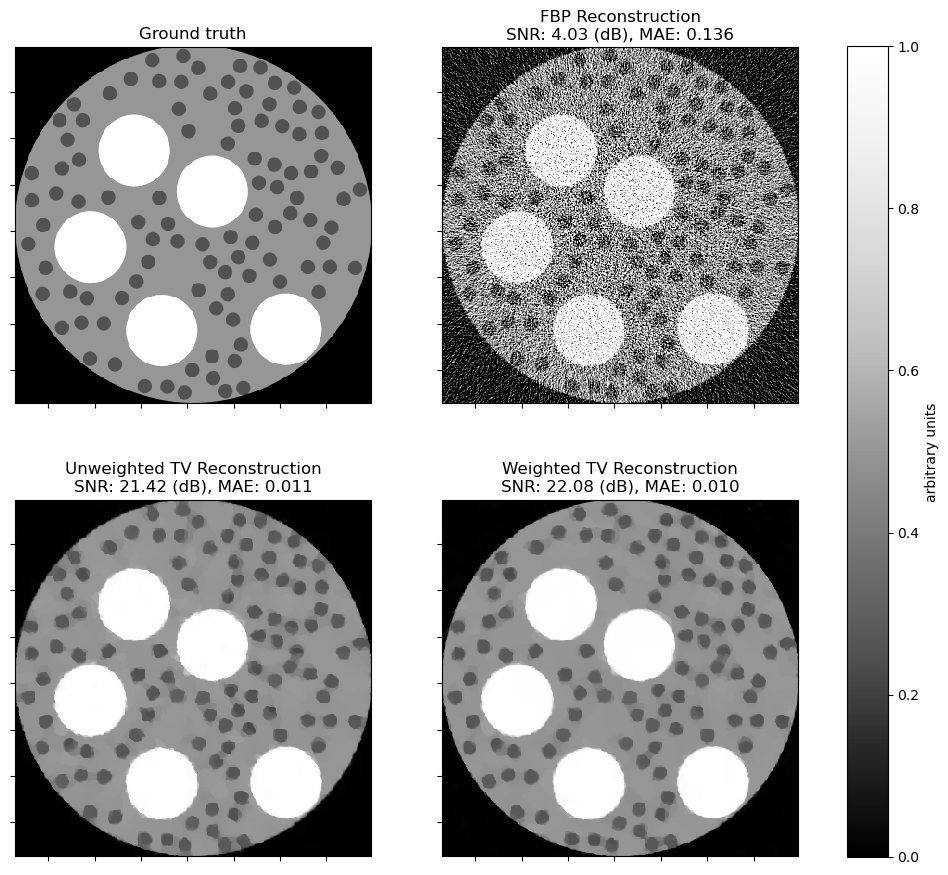

In [9]:
def plot_recon(x, title, ax):
    """Plot an image with title indicating error metrics."""
    plot.imview(
        x,
        title=f"{title}\nSNR: {metric.snr(x_gt, x):.2f} (dB), MAE: {metric.mae(x_gt, x):.3f}",
        fig=fig,
        ax=ax,
    )


fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0])
plot_recon(x0, "FBP Reconstruction", ax=ax[0, 1])
plot_recon(x_unweighted, "Unweighted TV Reconstruction", ax=ax[1, 0])
plot_recon(x_weighted, "Weighted TV Reconstruction", ax=ax[1, 1])
for ax_ in ax.ravel():
    ax_.set_xlim(64, 448)
    ax_.set_ylim(64, 448)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="arbitrary units"
)
fig.show()